# Forecast Daily Delivery & Take Away Turnover of a Restaurant

## 1. Import Required Modules

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from math import sqrt
import warnings

## 2. Load data

In [2]:
# Load data into dataframe
df = pd.read_csv("train_daily.csv")

## 3. Data Exploration

In [3]:
# Show missing values
df.isna().sum()

date                    0
turnover                0
public_holiday       1026
temperature             0
windspeed               0
humidity_relative       0
snow_fraction           0
precipitation           0
sunshine_duration       0
event_local          1052
school_holiday        833
temp_felt               0
weekday                 0
weekday_N               0
year_day_N              0
year_week_N             0
dtype: int64

In [4]:
# Function for creating a correlogram
def correlogram(df):
    # Create correlogram
    plt.figure(figsize = (18, 18), dpi = 122)
    sns.heatmap(df.corr(), xticklabels = df.corr().columns, yticklabels = df.corr().columns,
                cmap = "RdYlGn", center = 0, annot = True, cbar = False)

    # Create title and adjust font sizes
    plt.title("Correlogram", fontsize = 18)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    return plt.show()

# Create additional features

# Create new binary variables for categorical variables
df["public_holiday_binary"] = np.where(df["public_holiday"].isnull(), 0, 1)
df["event_local_binary"] = np.where(df["event_local"].isnull(), 0, 1)
df["school_holiday_binary"] = np.where(df["school_holiday"].isnull(), 0, 1)

# Fill NA/s in original columns with "Other"
df["public_holiday"] = df["public_holiday"].fillna("Other")
df["event_local"] = df["event_local"].fillna("Other")
df["school_holiday"] = df["school_holiday"].fillna("Other")

# Convert "date" column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Add "month_day_N", "month", "weekend", "weekend and holiday", "bridge_day", and "weekend_holiday_bridge_day" columns
df["month_day_N"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["weekend_binary"] = np.where(df["weekday_N"] > 5, 1, 0)
df["weekend_and_holiday"] = df["weekend_binary"] + df["public_holiday_binary"]
df["bridge_day"] = np.where(df["weekend_and_holiday"].shift(1) + df["weekend_and_holiday"].shift(-1) - df["weekend_and_holiday"] == 2, 1, 0)
df["weekend_holiday_bridge_day"] = (df["weekend_and_holiday"] + df["bridge_day"]).map({0:0, 1:1, 2:1})

# Add "after_pay_day" column for the last days of the month starting on the 25th
df["after_pay_day"] = np.where(df["month_day_N"] >= 25, 1, 0)

# Create new column for the restriction phase

# Create function:
# 0: Before First Lockdown
# 1: After First Lockdown dine-in possible
# 2: After First Lockdown only take-away/delivery possible

def restriction_phase(df):
    if df["date"] < dt.strptime("2020-03-17", "%Y-%m-%d"):
        return "Before Lockdown"
    elif (df["date"] >= dt.strptime("2020-03-17", "%Y-%m-%d")) and (df["date"] < dt.strptime("2020-12-22", "%Y-%m-%d")):
        return "Lockdown: Dine-In Possible"
    else:
        return "Lockdown: TakeAway Only"
df["restriction_phase"] = df.apply(restriction_phase, axis = 1)

# Add days since the initial opening of the restaurant
df["days_since_opening"] = np.arange(df.shape[0])

# Add columns for turnover 1 to 7 days prior
df["shift_1"] = df.turnover.shift(1)
df["shift_2"] = df.turnover.shift(2)
df["shift_3"] = df.turnover.shift(3)
df["shift_4"] = df.turnover.shift(4)
df["shift_5"] = df.turnover.shift(5)
df["shift_6"] = df.turnover.shift(6)
df["shift_7"] = df.turnover.shift(7)

# Encode categorical features as such
for col in ['public_holiday', 'event_local', 'school_holiday', 'weekday', 'public_holiday_binary',
            'event_local_binary', 'school_holiday_binary', 'month', 'weekend_binary', 'weekend_and_holiday',
            'bridge_day', 'weekend_holiday_bridge_day', 'after_pay_day', 'restriction_phase']:
    df[col] = df[col].astype("category")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1119 non-null   datetime64[ns]
 1   turnover                    1119 non-null   int64         
 2   public_holiday              1119 non-null   category      
 3   temperature                 1119 non-null   float64       
 4   windspeed                   1119 non-null   float64       
 5   humidity_relative           1119 non-null   float64       
 6   snow_fraction               1119 non-null   int64         
 7   precipitation               1119 non-null   float64       
 8   sunshine_duration           1119 non-null   int64         
 9   event_local                 1119 non-null   category      
 10  school_holiday              1119 non-null   category      
 11  temp_felt                   1119 non-null   float64     

In [6]:
# Show descriptive statistics
df.describe()

,turnover,temperature,windspeed,humidity_relative,snow_fraction,precipitation,sunshine_duration,temp_felt,weekday_N,year_day_N,year_week_N,month_day_N,days_since_opening,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1118.000000,1117.000000,1116.000000,1115.000000,1114.000000,1113.000000,1112.000000
mean,2899.127793,11.195318,3.046922,71.351121,0.015192,2.180867,356.784629,8.422390,4.000894,180.285970,26.305630,15.655943,559.000000,2897.097496,2895.461056,2892.806452,2889.737220,2884.948833,2882.768194,2880.405576
std,1551.829838,7.144088,2.039979,9.807152,0.122371,4.247734,262.420386,9.327035,2.001564,106.302924,15.220017,8.782124,323.171781,1551.036754,1550.765636,1548.919759,1546.215928,1538.617346,1537.585836,1536.255137
min,0.000000,-7.766667,0.368750,42.083333,0.000000,0.000000,0.000000,-17.107500,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,5.301458,1.619583,64.458333,0.000000,0.000000,119.000000,0.951250,2.000000,86.000000,13.000000,8.000000,279.500000,2001.000000,1997.000000,1996.750000,1996.500000,1996.250000,1996.000000,1994.750000
50%,2586.000000,11.096667,2.448750,71.541667,0.000000,0.000000,338.000000,8.060417,4.000000,179.000000,26.000000,16.000000,559.000000,2581.500000,2577.000000,2576.500000,2576.000000,2576.000000,2576.000000,2573.500000
75%,3621.000000,17.015000,3.810417,78.270833,0.000000,2.565000,557.000000,16.066250,6.000000,272.500000,39.500000,23.000000,838.500000,3618.500000,3614.000000,3611.000000,3605.500000,3600.750000,3600.000000,3594.750000
max,10019.000000,27.506250,12.936250,96.833333,1.000000,40.000000,959.000000,30.373333,7.000000,366.000000,53.000000,31.000000,1118.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000,10019.000000


In [7]:
# Remove days where the restaurant was closed
df = df[df["turnover"] != 0]

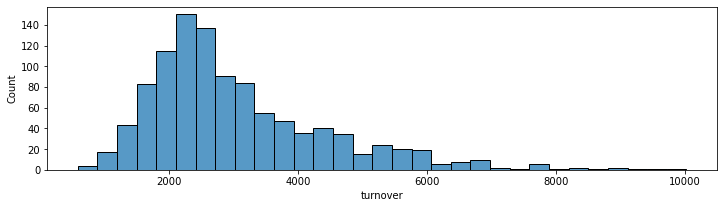

In [8]:
# Plot turnover distribution
plt.figure(figsize = (12, 3))
sns.histplot(data = df["turnover"]);

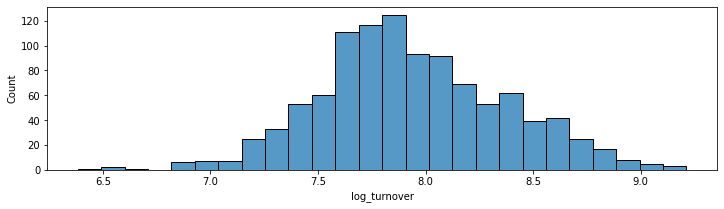

In [9]:
# Turnover is right skewed, so a logarithmic transformation will be used to normalise the data.
df["log_turnover"] = np.log(df["turnover"])

# Plot log_turnover distribution
plt.figure(figsize = (12, 3))
sns.histplot(data = df["log_turnover"]);

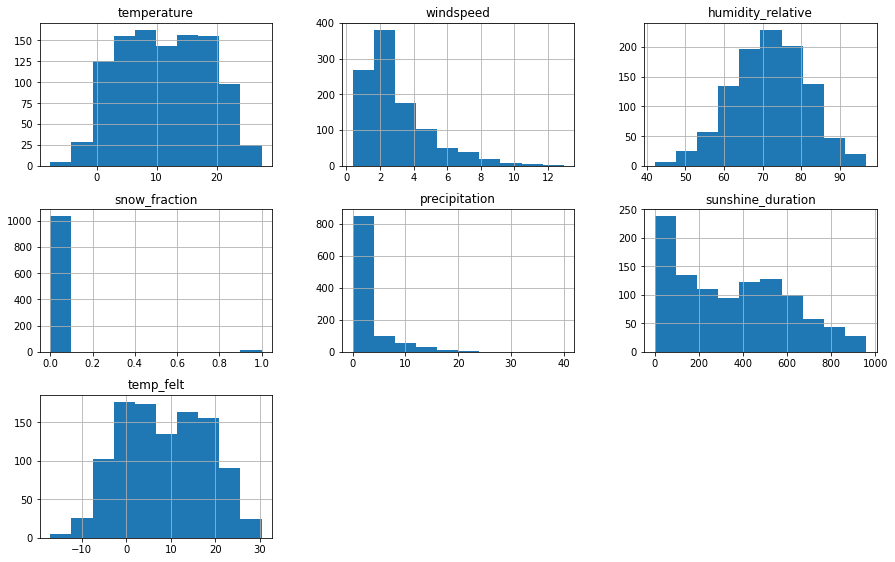

In [10]:
X_continuous = ['temperature', 'windspeed',
       'humidity_relative', 'snow_fraction', 'precipitation',
       'sunshine_duration', 'temp_felt']
df[X_continuous].hist(figsize=(15,30),layout=(9,3));

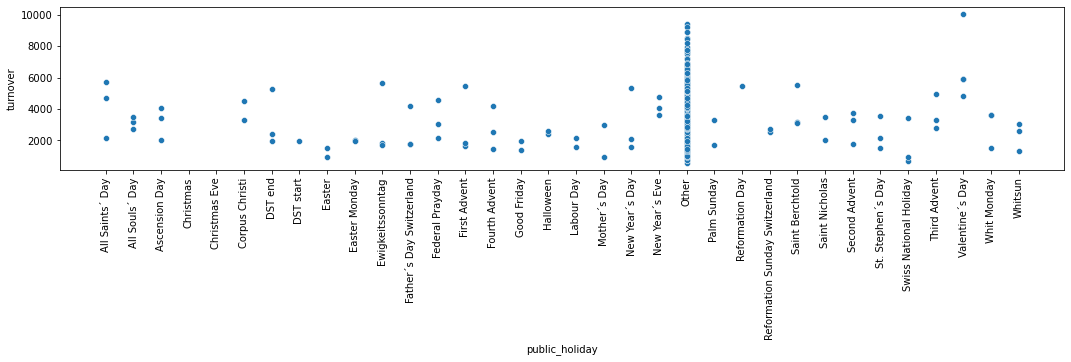

In [11]:
plt.figure(figsize = (18, 3))
sns.scatterplot(data = df, x = "public_holiday", y = "turnover")
plt.xticks(rotation = 90);

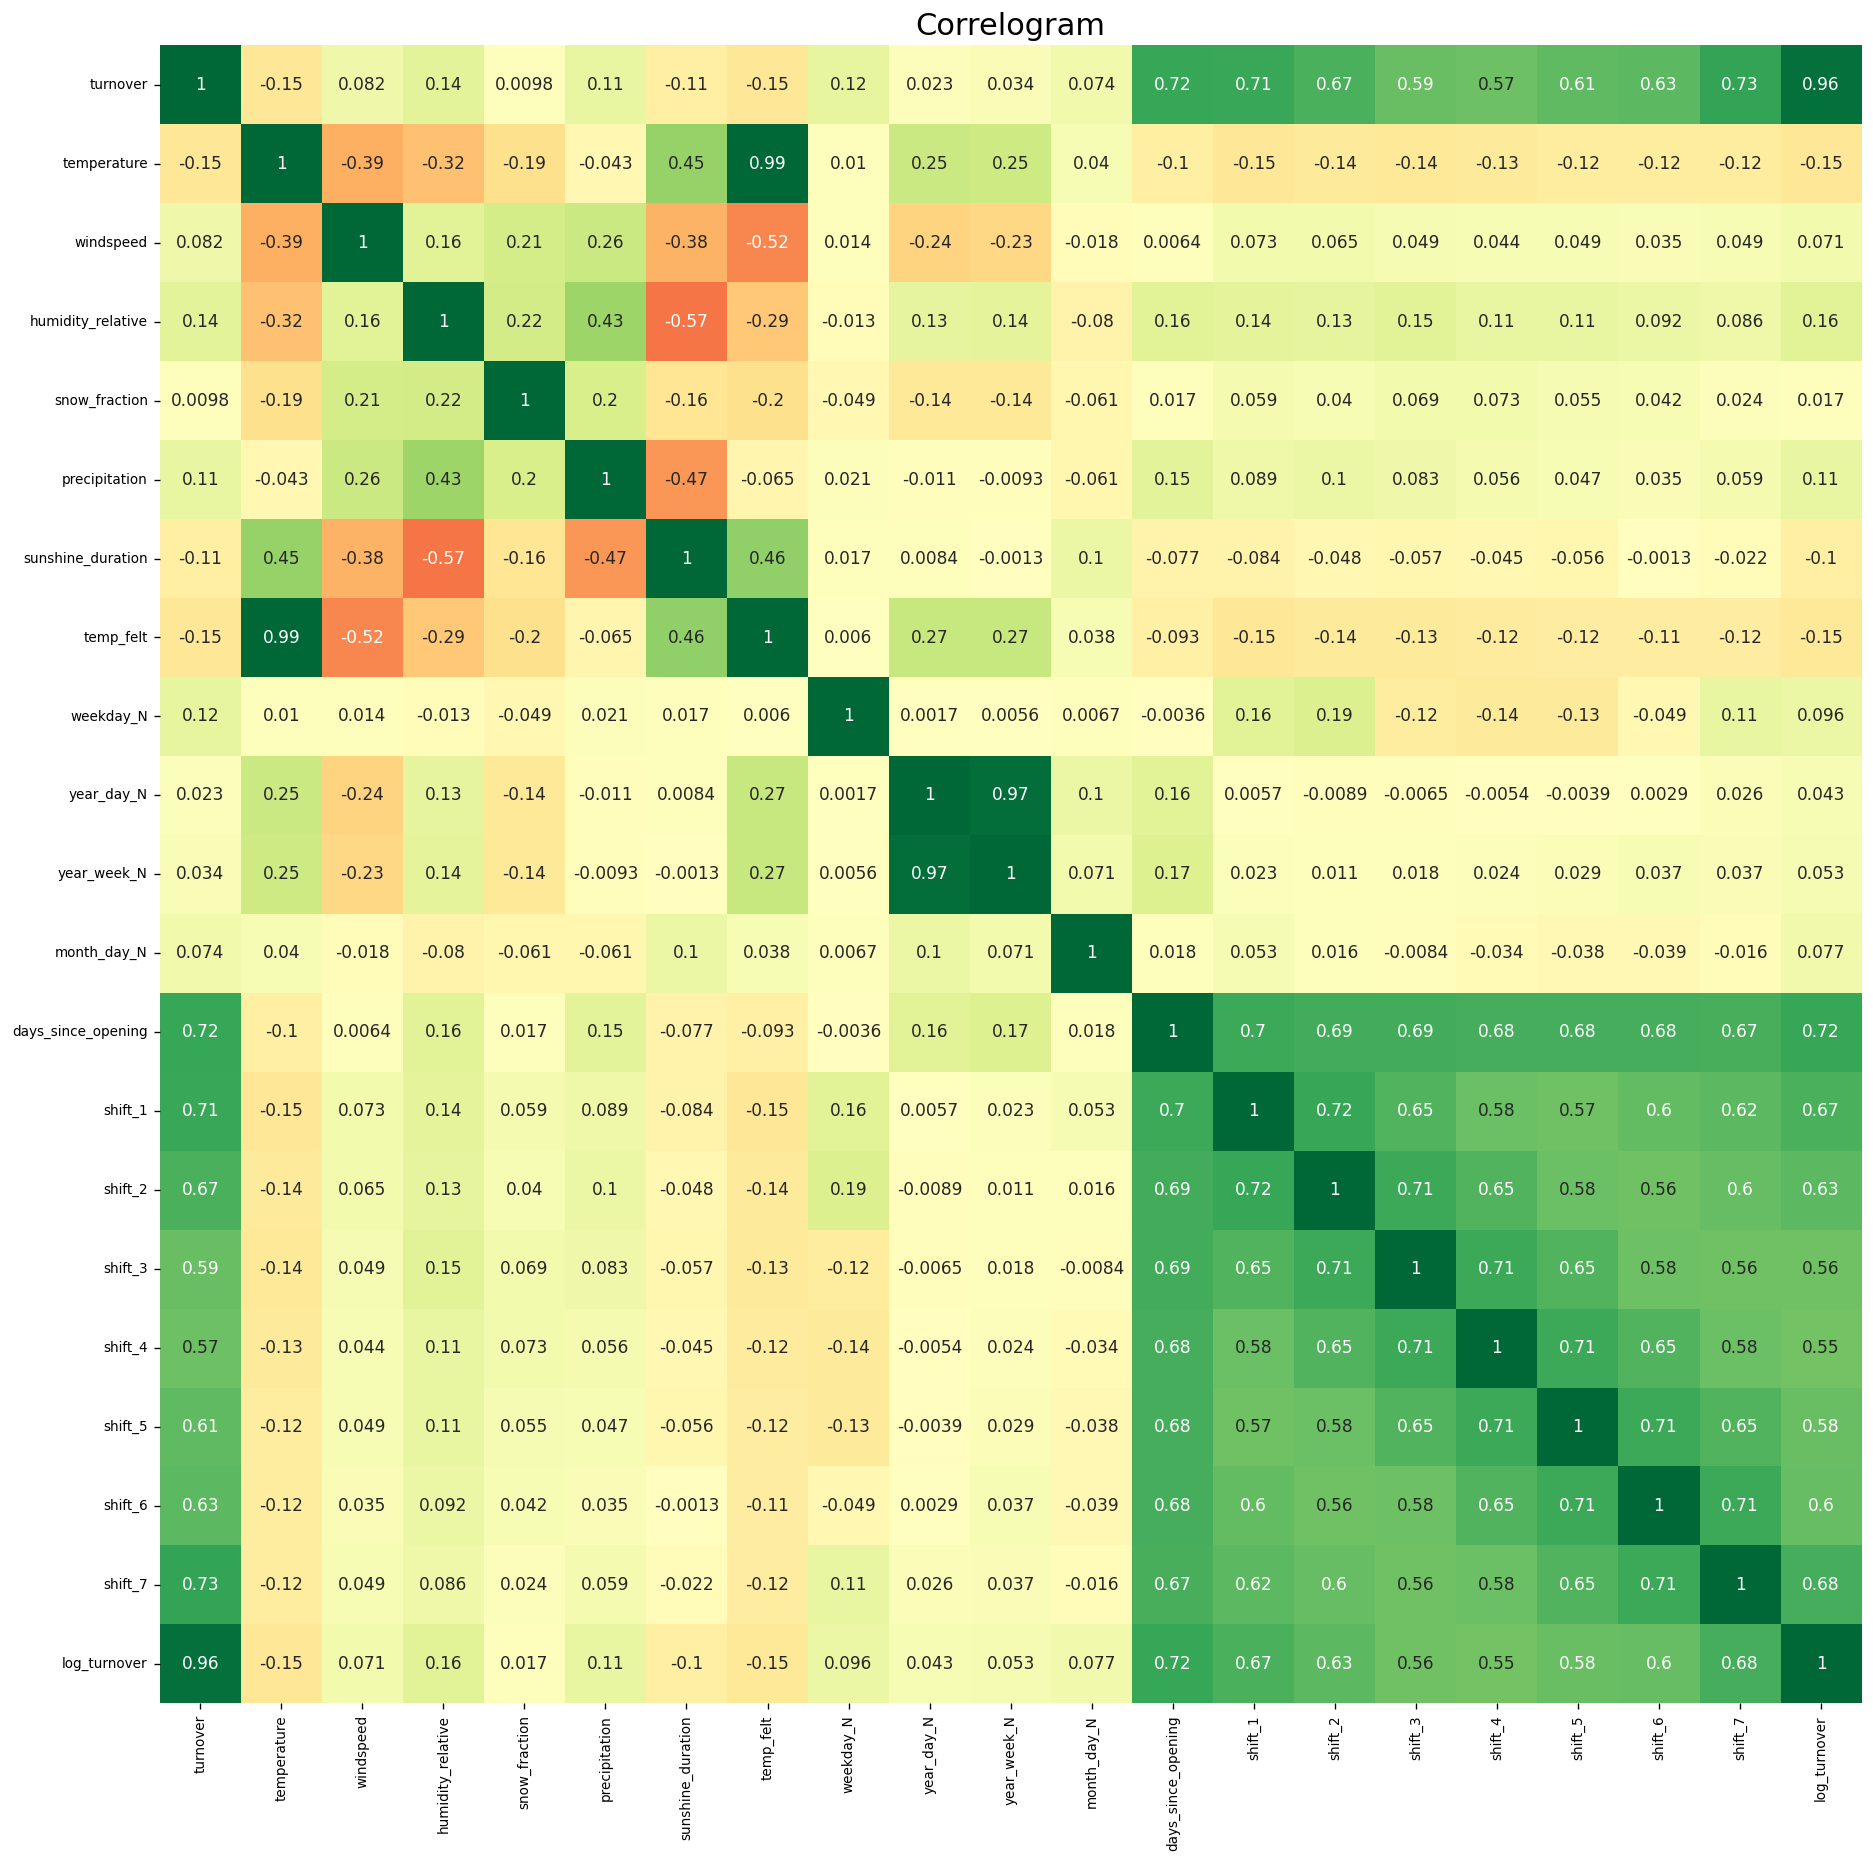

In [12]:
# Plot correlogram
correlogram(df)

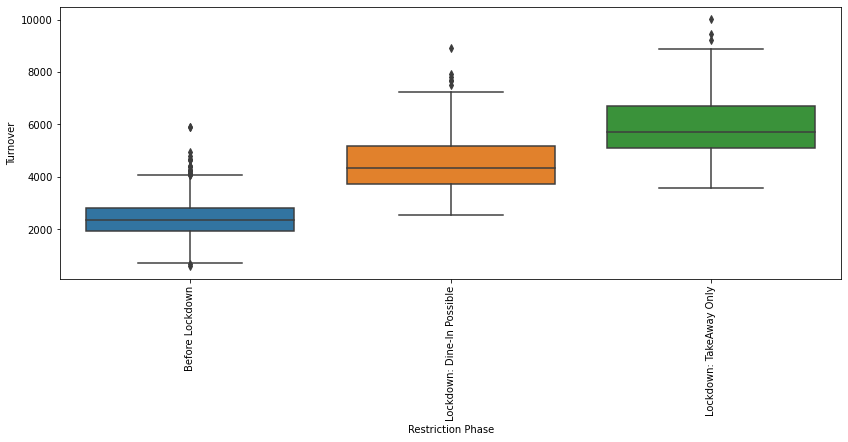

In [14]:
plt.figure(figsize = (14, 5))
sns.boxplot(x = 'restriction_phase', y = "turnover", data = df)
plt.xlabel("Restriction Phase")
plt.ylabel("Turnover")
plt.xticks(rotation = 90);

Turnover increased considerably during the lockdown, especially once restaurants were only able to offer takeaway.

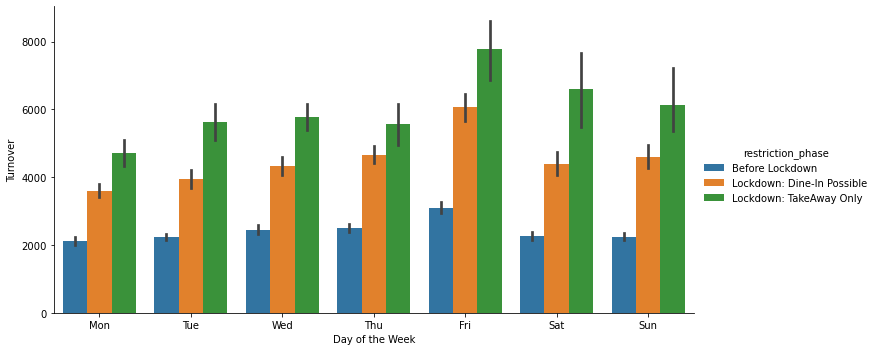

In [15]:
sns.catplot(x = "weekday_N", y = "turnover", hue = "restriction_phase", kind = "bar", data = df, height = 5, aspect = 2)
plt.xlabel("Day of the Week")
plt.ylabel("Turnover")
plt.xticks([0, 1, 2, 3, 4, 5, 6, ], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

Over the entire period, Fridays generated the most turnover. While Thursdays used to be the second most profitable day before the pandemic, this remained so only during the time when dine-in was still possible during the pandemic. When restaurants could only offer takeaway food, Saturdays and Sundays became the second and third most profitable days.

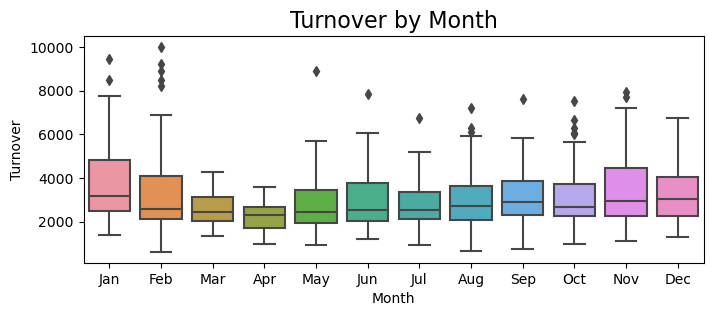

month
1     3767.204301
11    3435.288889
2     3346.388889
12    3318.264368
9     3181.222222
10    3077.236559
6     2938.932584
8     2922.494624
5     2822.036145
7     2821.869565
3     2552.525641
4     2261.850000
Name: turnover, dtype: float64

In [16]:
# Plot turnover by Month
plt.figure(figsize = (8, 3), dpi = 100)
sns.boxplot(x = df["month"], y = df["turnover"])
plt.title("Turnover by Month", fontsize = 16)
plt.xlabel("Month")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel("Turnover")
plt.show()

turnover_all = df.groupby("month").mean().sort_values("turnover", ascending= False)["turnover"]
turnover_all

January was the most profitable month of the year, followed by November, February and December. During Spring time and Summer, sales have historically been the lowest.

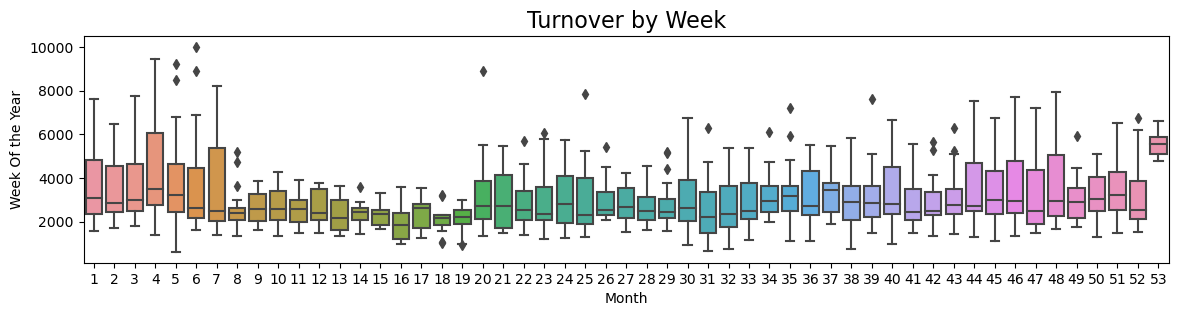

year_week_N
53    5544.285714
4     4379.047619
5     3870.800000
3     3667.619048
1     3664.333333
46    3657.904762
6     3608.892857
48    3581.000000
44    3578.761905
7     3449.071429
51    3417.952381
2     3410.904762
40    3344.809524
50    3286.190476
37    3283.666667
45    3265.714286
52    3256.000000
35    3254.761905
20    3232.285714
39    3216.809524
34    3200.142857
36    3084.809524
43    3080.285714
47    3079.666667
25    3068.400000
24    3060.190476
21    3049.380952
49    3045.476190
38    3005.000000
30    2953.619048
26    2916.809524
42    2894.190476
22    2878.000000
23    2875.000000
33    2846.142857
41    2835.476190
27    2829.095238
29    2791.900000
28    2701.095238
32    2699.000000
12    2683.533333
10    2652.142857
9     2615.476190
31    2573.857143
8     2556.565217
11    2511.047619
17    2392.642857
14    2362.928571
13    2299.214286
15    2264.071429
19    2119.785714
18    2102.785714
16    2004.285714
Name: turnover, dtype: float64

In [17]:
# Plot turnover by Week
plt.figure(figsize = (14, 3), dpi = 100)
sns.boxplot(x = df["year_week_N"], y = df["turnover"])
plt.title("Turnover by Week", fontsize = 16)
plt.xlabel("Month")
plt.ylabel("Week Of the Year")
plt.show()

df.groupby("year_week_N").mean().sort_values("turnover", ascending= False)["turnover"]

When further breaking down turnover by week, it becomes evident that especially the end of December, as well as January to Mid-February are among the most profitable weeks of the year.

### Fit Models

In [19]:
# Create new DataFrame without null values
df_reg = df.dropna()
X = df_reg[['public_holiday', 'temperature', 'windspeed',
       'humidity_relative', 'snow_fraction', 'precipitation',
       'sunshine_duration', 'event_local', 'school_holiday', 'temp_felt',
       'weekday', 'weekday_N', 'year_day_N', 'year_week_N',
       'public_holiday_binary', 'event_local_binary', 'school_holiday_binary',
       'month_day_N', 'month', 'weekend_binary', 'weekend_and_holiday',
       'bridge_day', 'weekend_holiday_bridge_day', 'after_pay_day',
       'restriction_phase', 'days_since_opening', 'shift_1', 'shift_2',
       'shift_3', 'shift_4', 'shift_5', 'shift_6', 'shift_7']]
y = df_reg['turnover']
y_log = df_reg['log_turnover']

In [20]:
X.shape, y.shape

((1049, 33), (1049,))

In [21]:
# Split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
# Try different linear models and print their mean score from 20 cross validations

warnings.simplefilter('ignore',lineno = 0)
regressor_list = [linear_model.Ridge(), linear_model.RidgeCV(), linear_model.SGDRegressor(),
                  linear_model.ElasticNet(), linear_model.ElasticNetCV(),
                  linear_model.Lasso(), linear_model.LassoCV(),
                  linear_model.LassoLars(), linear_model.LassoLarsCV(), linear_model.LassoLarsIC(), 
                  linear_model.OrthogonalMatchingPursuit(), linear_model.OrthogonalMatchingPursuitCV()]

results_dict = {}

preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), selector(dtype_exclude = "category")),
                                                 ('cat', OneHotEncoder(handle_unknown = 'ignore'),
                                                  selector(dtype_include = "category"))])

for regressor in regressor_list:
    reg = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(reg, X_train, y_train, cv = 20)
    results_dict[regressor] = np.mean(scores)

results_df = pd.DataFrame(results_dict, index = ["Score"])
results_df = results_df.transpose().sort_values(by = "Score", ascending = False)
results_df.round(4)

,Score
LassoLars(),0.7574
LassoLarsIC(),0.7567
LassoLarsCV(),0.7554
Lasso(),0.7507
Ridge(),0.7399
LassoCV(),0.7343
OrthogonalMatchingPursuitCV(),0.7311
OrthogonalMatchingPursuit(),0.7310
"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.7283
SGDRegressor(),0.7255


In [23]:
# Use LassoLars to predict sales
reg = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', linear_model.LassoLars())])
reg.fit(X_train, y_train)
print("Mean Classifier Score (20 CVs): ", np.mean(cross_val_score(reg, X_train, y_train, cv = 20)))

Mean Classifier Score (20 CVs):  0.7573941504715858


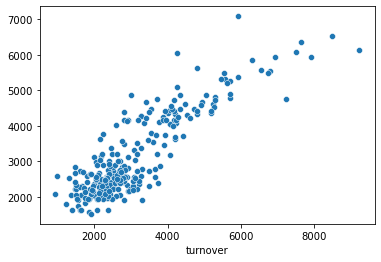

In [24]:
y_pred = reg.predict(X_test)
plot = sns.scatterplot(x = y_test, y = y_pred)

In [25]:
predicted = pd.DataFrame(reg.predict(X_test), columns = ['turnover'])
predicted.tail(3)

,turnover
260,2185.946002
261,2542.678595
262,3458.989222


#### Try logarithm of predictor

In [26]:
X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log)
X_train.shape, X_test.shape, y_log_train.shape, y_log_test.shape

((786, 33), (263, 33), (786,), (263,))

In [27]:
# Try different linear models and print score from 20 cross validations

warnings.simplefilter('ignore',lineno = 0)
results_dict = {}

preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), selector(dtype_exclude = "category")),
                                                 ('cat', OneHotEncoder(handle_unknown = 'ignore'),
                                                  selector(dtype_include = "category"))])

for regressor in regressor_list:
    reg = Pipeline(steps = [('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(reg, X_train, y_log_train, cv = 20)
    results_dict[regressor] = np.mean(scores)

results_df = pd.DataFrame(results_dict, index = ["Score"])
results_df = results_df.transpose().sort_values(by = "Score", ascending = False)
results_df.round(4)

,Score
LassoLarsCV(),0.6905
LassoLarsIC(),0.6904
ElasticNetCV(),0.6838
LassoCV(),0.6836
"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.6793
Ridge(),0.6792
OrthogonalMatchingPursuit(),0.6764
OrthogonalMatchingPursuitCV(),0.6730
SGDRegressor(),0.4676
ElasticNet(),-0.0274


Using the logarithm of the turnover worsens the performance of all models.